In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,precision_score

from warnings import filterwarnings
filterwarnings(action='ignore')

In [16]:
df=pd.read_csv('diabetes.csv')
df = pd.DataFrame(df)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [17]:
duplicate = df.duplicated()
print(duplicate.sum())
df[duplicate]
df.drop_duplicates(inplace = True)

0


In [18]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [20]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [21]:
df.isnull().mean()*100

Pregnancies                  0.000000
Glucose                      0.651042
BloodPressure                4.557292
SkinThickness               29.557292
Insulin                     48.697917
BMI                          1.432292
DiabetesPedigreeFunction     0.000000
Age                          0.000000
Outcome                      0.000000
dtype: float64

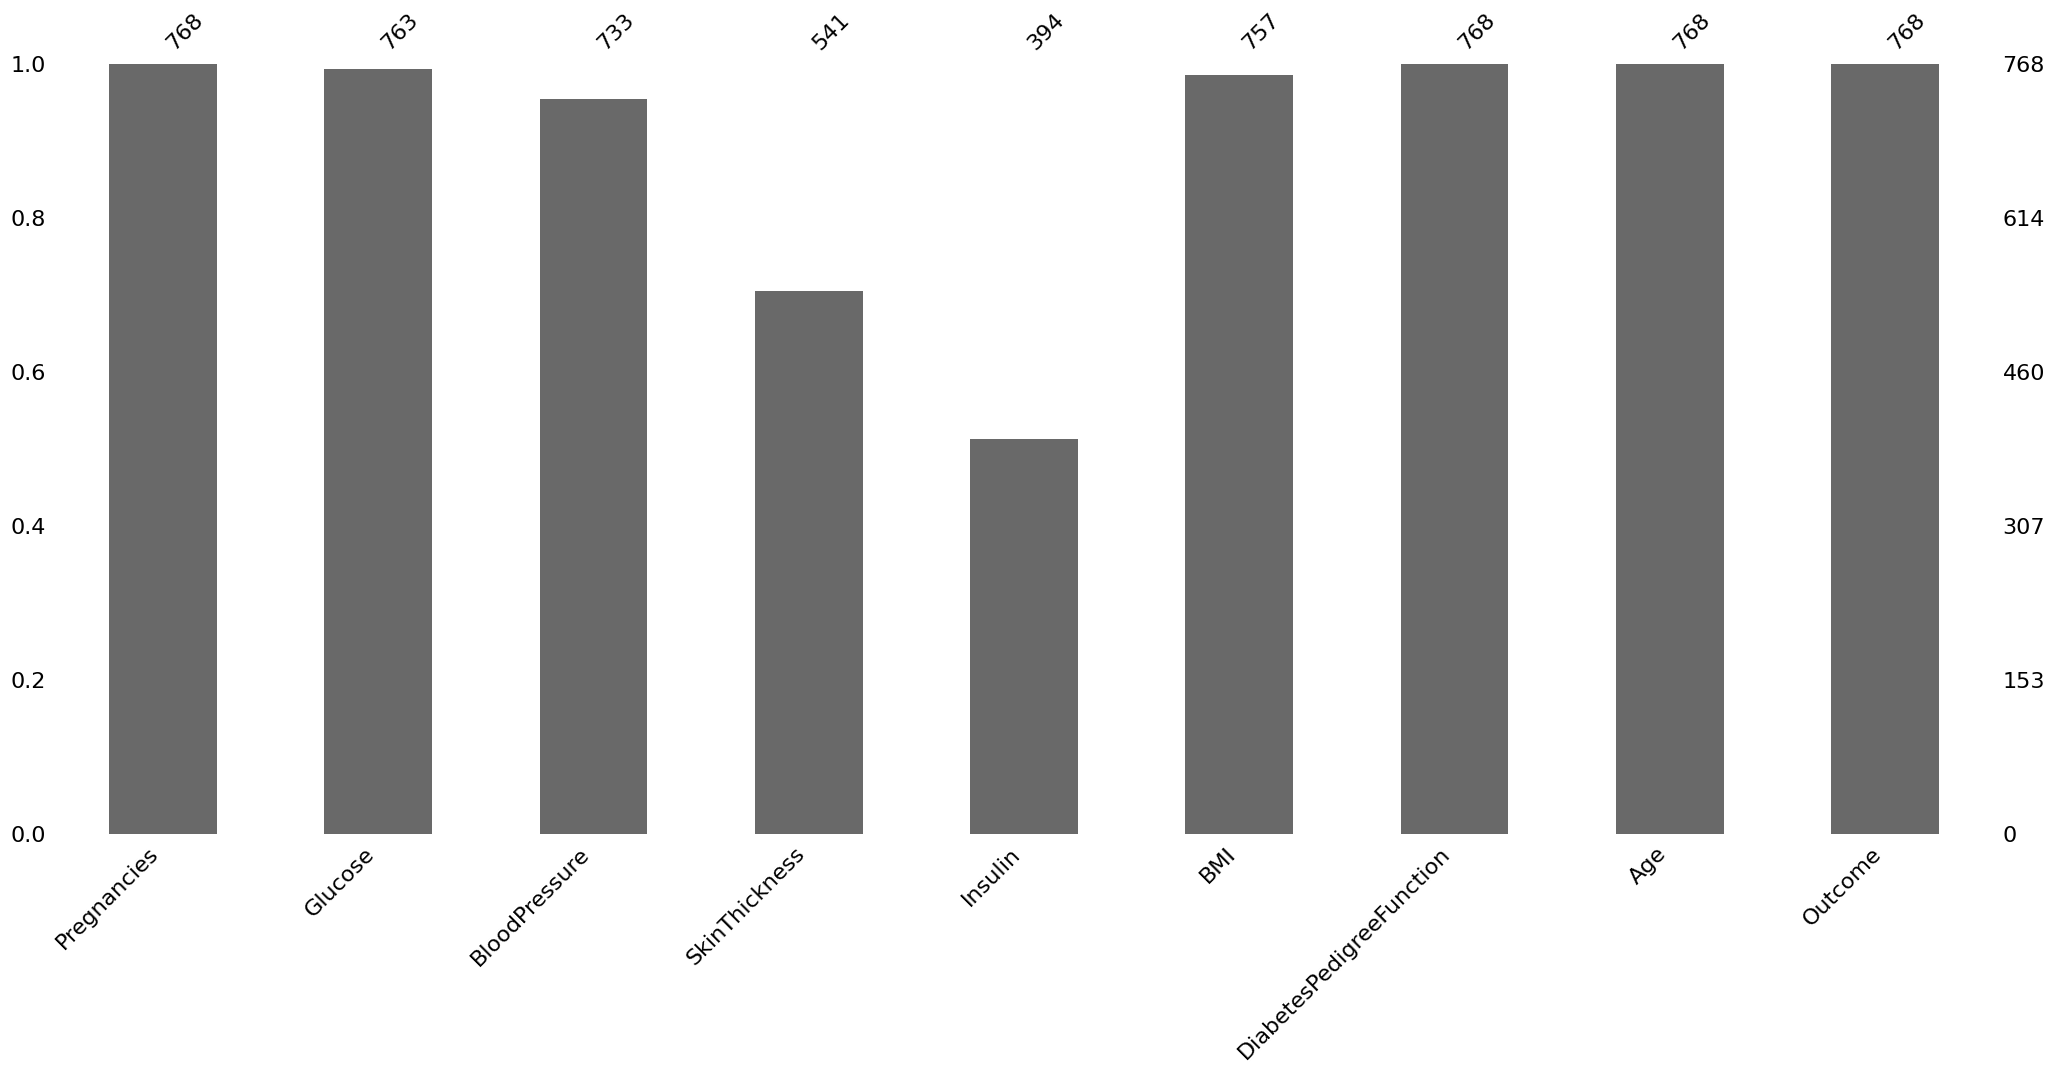

In [22]:
msno.bar(df)
plt.show()

In [23]:
# The missing values will be filled with the median values of each variable.
def median_target(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [24]:
# The values to be given for incomplete observations are given the median value of people who are not sick and the median values of people who are sick.
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_target(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_target(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_target(i)[i][1]

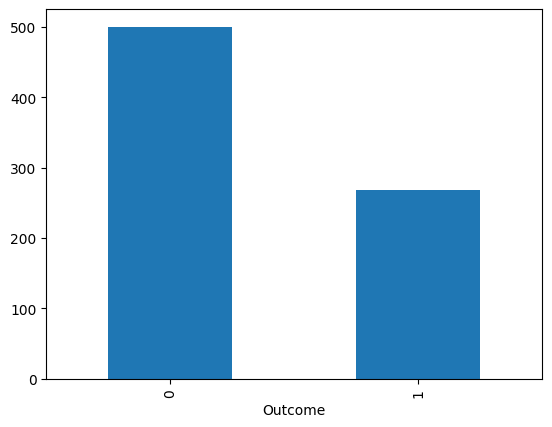

In [25]:
df['Outcome'].value_counts().plot(kind = 'bar')
plt.show()

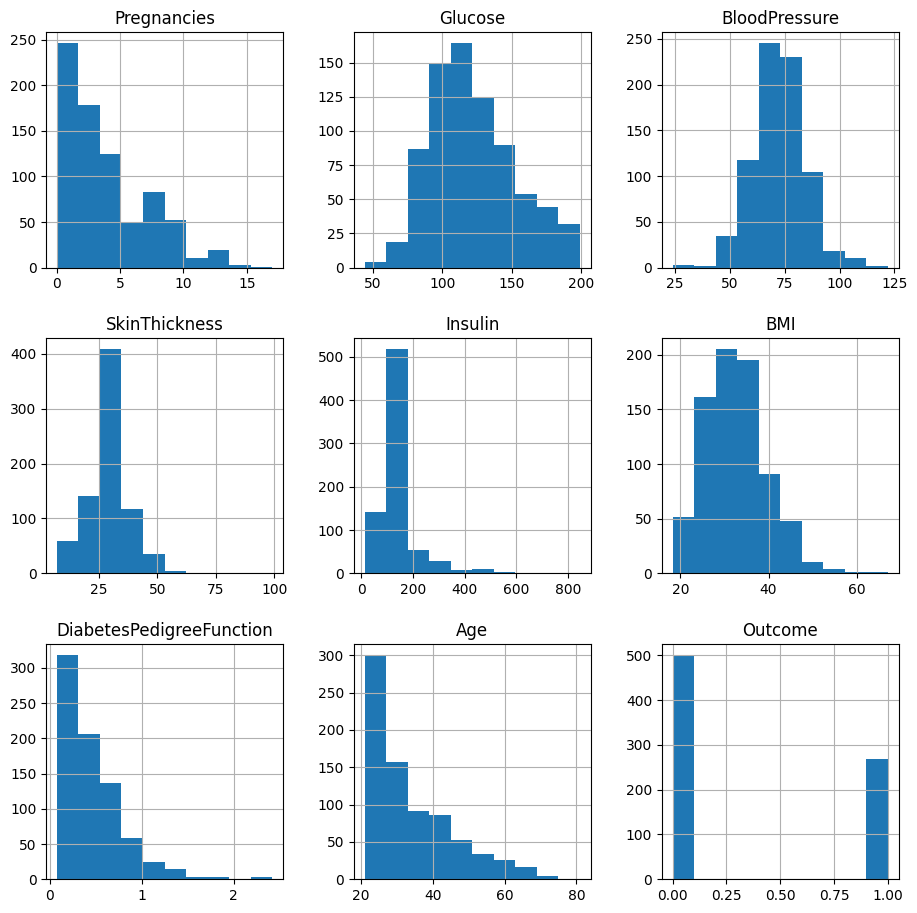

In [26]:
df.hist(figsize=(11,11));
plt.show()

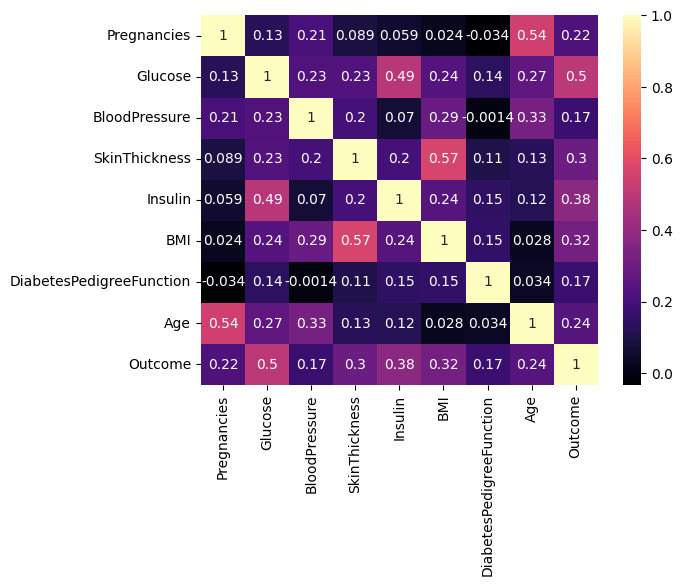

In [28]:
sns.heatmap(df.corr(),annot=True,cmap="magma")
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Outcome',axis=1), df['Outcome'], test_size=0.2, random_state=42)

In [30]:
# It will remove the first feature that is correlated with anything other feature

def correlation(dataset , threshold):
    
     # Input validation
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input 'dataset' must be a pandas DataFrame.")
    if not (-1 <= threshold <= 1):
        raise ValueError("Threshold must be between -1 and 1.")
        
    col_corr = set() # set of all the names of correlated column
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i] # Getting the name of the colummn
                col_corr.add(colname)
    return col_corr

In [31]:
corr_features = correlation(X_train , 0.8)
len(set(corr_features))

0

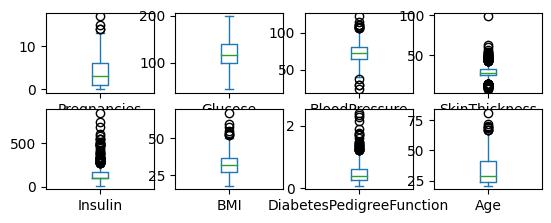

In [32]:
df.drop('Outcome' ,axis = 1).plot(kind = 'box' , subplots = True , layout = (4,4) , sharex = False)
plt.show()

In [33]:
def cap_data(df):
    df_copy = df.copy()  
    for col in df_copy.columns:
        print("capping the", col)
        if df_copy[col].dtype in [float, int]:  # No need for separate checks
            percentiles = df_copy[col].quantile([0.25, 0.75]).values
            df_copy[col][df_copy[col] <= percentiles[0]] = percentiles[0]
            df_copy[col][df_copy[col] >= percentiles[1]] = percentiles[1]
    return df_copy

In [34]:
final_df = cap_data(df.drop('Outcome' , axis = 1))
final_df['Outcome'] = df['Outcome'].copy()

capping the Pregnancies
capping the Glucose
capping the BloodPressure
capping the SkinThickness
capping the Insulin
capping the BMI
capping the DiabetesPedigreeFunction
capping the Age


In [35]:
final_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,140.25,72.0,32.0,169.5,33.6,0.62625,50,1
1,1,99.75,66.0,29.0,102.5,27.5,0.35100,31,0
2,8,140.25,64.0,32.0,169.5,27.5,0.62625,32,1
3,1,99.75,66.0,25.0,102.5,28.1,0.24375,21,0
4,0,137.00,64.0,32.0,168.0,36.6,0.62625,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.00,76.0,32.0,169.5,32.9,0.24375,63,0
764,2,122.00,70.0,27.0,102.5,36.6,0.34000,27,0
765,5,121.00,72.0,25.0,112.0,27.5,0.24500,30,0
766,1,126.00,64.0,32.0,169.5,30.1,0.34900,47,1


In [36]:
plot_frame = final_df.groupby('Age')[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction']].mean().reset_index()
plot_frame.head(5)

,Age,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction
0,21,1.079365,112.797619,68.682540,27.000000,118.158730,30.417460,0.406282
1,22,1.555556,112.958333,69.138889,27.583333,120.812500,30.622222,0.399101
2,23,1.578947,113.605263,70.434211,28.394737,129.197368,31.405263,0.417875
3,24,1.891304,116.614130,69.836957,28.565217,122.423913,32.447826,0.387098
4,25,1.770833,112.484375,68.302083,28.479167,123.562500,32.339583,0.430542


In [37]:
def plot(df, df_target_column, list_of_imputed_columns):
    
    for imputed_column in list_of_imputed_columns:
        
        sns.kdeplot(x=df[df_target_column], y=df[imputed_column], fill=True, color = 'm')
        plt.xlabel(df_target_column)
        plt.ylabel(imputed_column)
        plt.legend()
        plt.title(f'Histogram for {imputed_column} based on {df_target_column}')
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


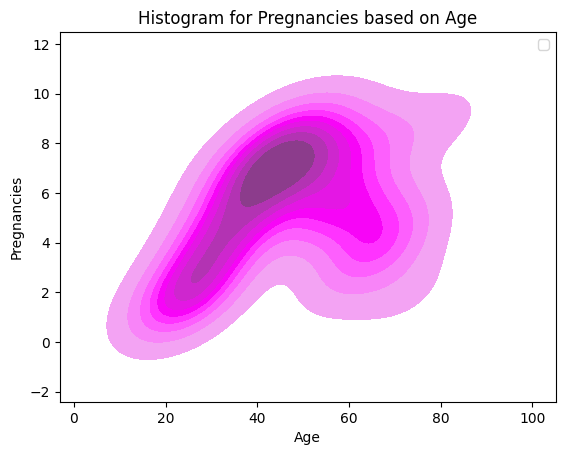

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


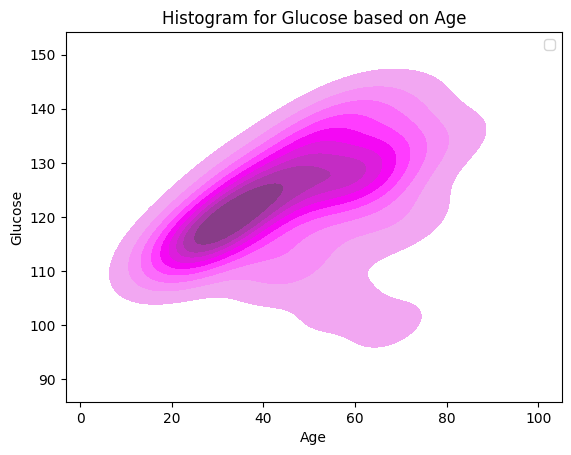

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


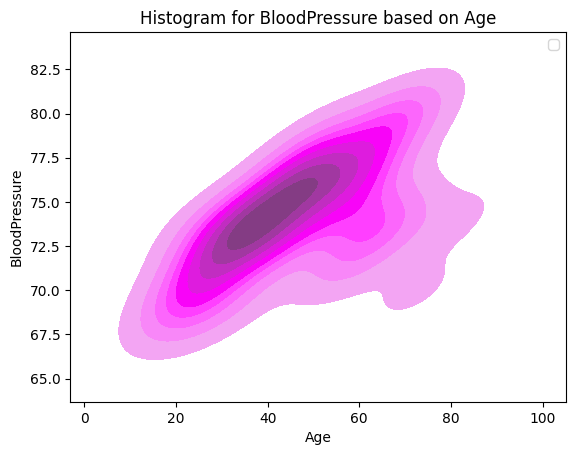

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


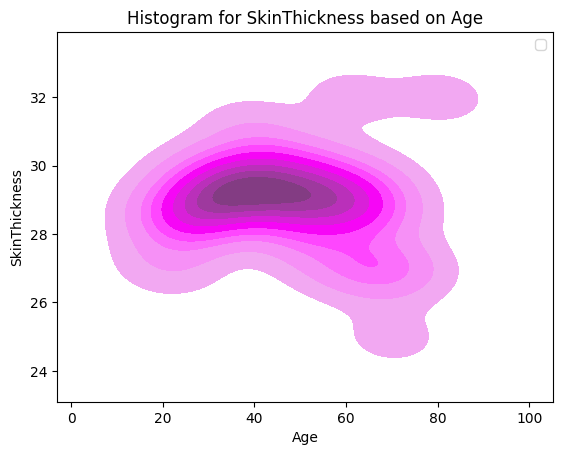

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


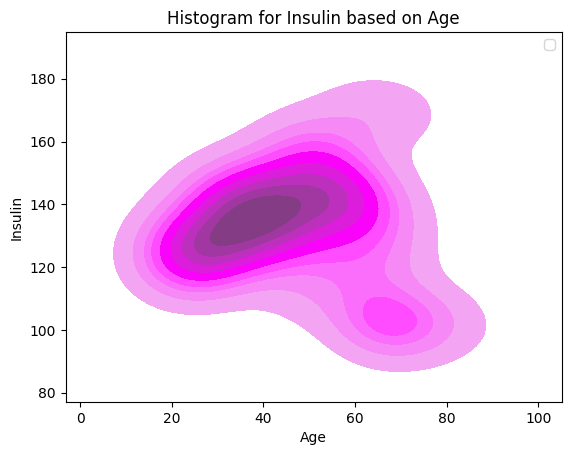

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


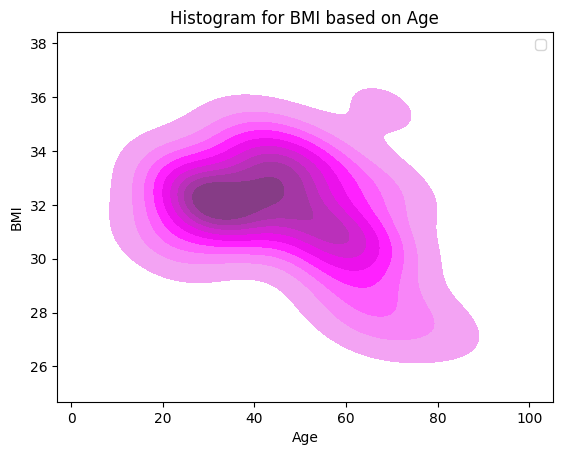

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


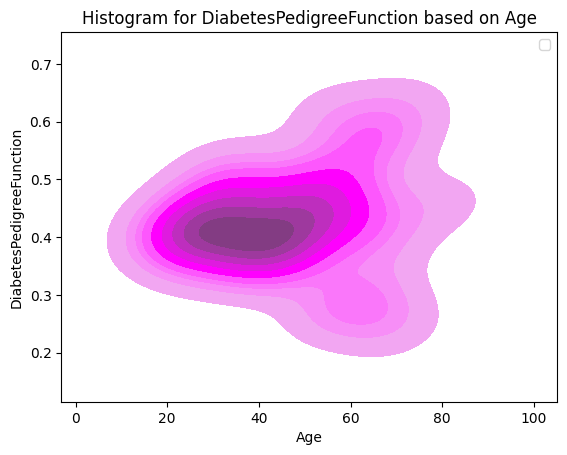

In [38]:
plot(plot_frame , 'Age' , ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction'])

In [39]:
scaler = MinMaxScaler()
X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,IsolationForest,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [41]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
ifc = IsolationForest(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)
cat = CatBoostClassifier(n_estimators=50,random_state=2)
lgb = LGBMClassifier(n_estimators=50,random_state=2)

In [42]:
classifiers = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'ifc': ifc,
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb,
    'cat':cat,
    'lgb':lgb
}

In [43]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted') 
    
    return accuracy, precision

In [44]:
accuracy_scores = []
precision_scores = []

for name,clf in classifiers.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train_trf,y_train,X_test_trf,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.5194805194805194
Precision -  0.4558840058446668
For  KN
Accuracy -  0.7597402597402597
Precision -  0.7684582248046484
For  NB
Accuracy -  0.6428571428571429
Precision -  0.413265306122449
For  DT
Accuracy -  0.8636363636363636
Precision -  0.8624999999999999
For  LR
Accuracy -  0.7792207792207793
Precision -  0.7763726849963286
For  RF
Accuracy -  0.8831168831168831
Precision -  0.884324212593339
For  ifc
Accuracy -  0.2662337662337662
Precision -  0.11351052048726468
For  AdaBoost
Accuracy -  0.8441558441558441
Precision -  0.8499660043816575
For  BgC
Accuracy -  0.8701298701298701
Precision -  0.8714311552076067
For  ETC
Accuracy -  0.8441558441558441
Precision -  0.8441558441558441
For  GBDT
Accuracy -  0.8636363636363636
Precision -  0.8658405172413793
For  xgb
Accuracy -  0.8701298701298701
Precision -  0.8693389554588882
Learning rate set to 0.130475
0:	learn: 0.6398654	total: 122ms	remaining: 5.97s
1:	learn: 0.5962943	total: 126ms	remaining: 3.03s
2:	lea

In [45]:
performance_df = pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy':accuracy_scores , 'Precision': precision_scores})
performance_df

,Algorithm,Accuracy,Precision
0,SVC,0.519481,0.455884
1,KN,0.759740,0.768458
2,NB,0.642857,0.413265
3,DT,0.863636,0.862500
4,LR,0.779221,0.776373
5,RF,0.883117,0.884324
6,ifc,0.266234,0.113511
7,AdaBoost,0.844156,0.849966
8,BgC,0.870130,0.871431
9,ETC,0.844156,0.844156


In [46]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,SVC,Accuracy,0.519481
1,KN,Accuracy,0.759740
2,NB,Accuracy,0.642857
3,DT,Accuracy,0.863636
4,LR,Accuracy,0.779221
5,RF,Accuracy,0.883117
6,ifc,Accuracy,0.266234
7,AdaBoost,Accuracy,0.844156
8,BgC,Accuracy,0.870130
9,ETC,Accuracy,0.844156


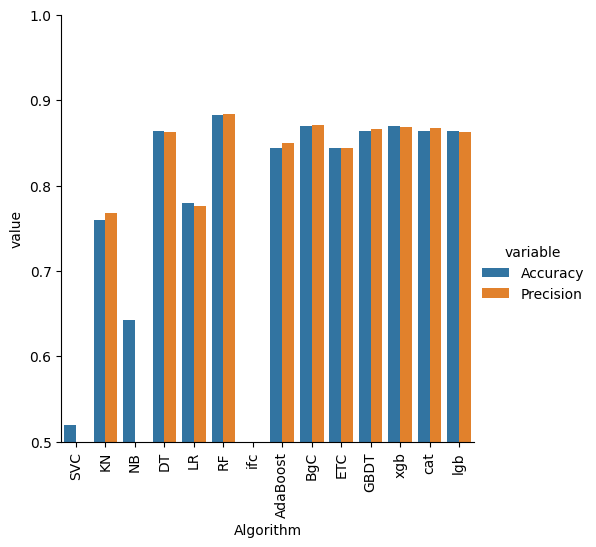

In [47]:
# Categorical Plot
sns.catplot(x='Algorithm', y='value', hue='variable', data=performance_df1, kind='bar', height=5) 
plt.ylim(0.5, 1.0)
plt.xticks(rotation='vertical')
plt.show()

In [48]:
from sklearn.ensemble import VotingClassifier

In [49]:
voting = VotingClassifier(estimators=[
    ('RF', rfc),
    ('xgb', xgb),
    ('bgc', bc)
],voting='soft')

In [50]:
voting.fit(X_train_trf , y_train)
y_pred = voting.predict(X_test_trf)
print('Accuracy Score is ::',accuracy_score(y_test , y_pred))

Accuracy Score is :: 0.8831168831168831


In [51]:
X = final_df.iloc[: , :8]
y = final_df.iloc[: , -1]
print(np.mean(cross_val_score(voting ,X , y ,cv=10 , scoring='accuracy')))

## ACCURACY IS 86% :D

0.8646103896103895
